In [1]:
import torch as t
import torch.nn as nn

from jaxtyping import Float, Int
from torch import Tensor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1: create a true function

In [381]:
def true_function(x: Tensor, noise:bool = False) -> Tensor:
    y = t.sin(10*x)
    
    if noise:
        y += t.normal(0, 0.2, size=y.shape)
    return y

In [382]:
x = t.linspace(-1, 1, 100)
y_true = true_function(x)
df_true = pd.DataFrame(zip(x.numpy(), y_true.numpy()), columns = ["x", "y"])

x_train = t.linspace(-1, 1, 20)
y_train = true_function(x_train, noise = True)
df_train = pd.DataFrame(zip(x_train.numpy(), y_train.numpy()), columns = ["x", "y"])

x_test = t.linspace(-1, 1, 100)
y_test = true_function(x_test, noise = True)
df_test = pd.DataFrame(zip(x_test.numpy(), y_test.numpy()), columns = ["x", "y"])

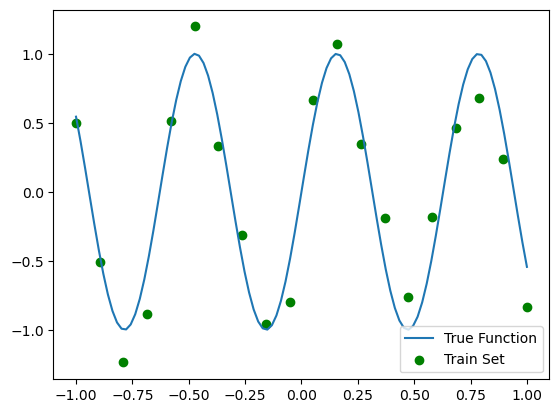

In [406]:
plt.plot(df_true["x"], df_true["y"], label = "True Function")
plt.scatter(df_train["x"], df_train["y"], label = "Train Set", c = "green")
plt.legend()

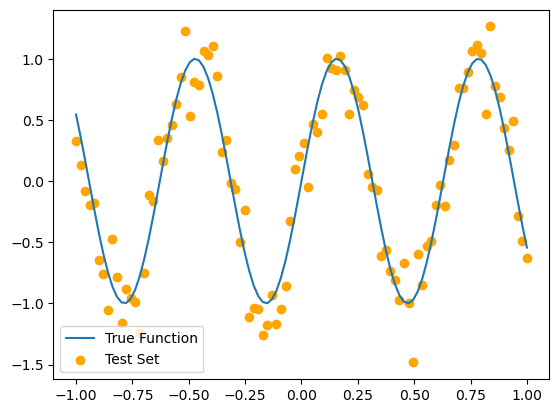

In [408]:
plt.plot(df_true["x"], df_true["y"], label = "True Function")
# plt.scatter(df_train["x"], df_train["y"])
plt.scatter(df_test["x"], df_test["y"], c = "orange", label = "Test Set")
plt.legend()

# 2: Create Model

In [339]:
class LinReg(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.in_features = in_features
        
        self.linear = nn.Linear(in_features, 1, bias = True)
        nn.init.zeros_(self.linear.weight) #initialize to zero
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        assert x.shape[1] == self.in_features
        return self.linear(x)

In [340]:
model = LinReg(10)
model.linear.weight

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

In [341]:
model.linear.bias

Parameter containing:
tensor([0.], requires_grad=True)

## Create Chebyshev Polynomial for Orthogonality

In [342]:
def get_chebyshev_polynomial(x: Float[Tensor, "batch"], degree: int) -> Float[Tensor, "batch n_features"]:
    batch = x.shape[0]
    res = t.zeros(batch, degree + 1)

    res[:, 0] = 1
    if degree == 0:
        return res
    res[:, 1] = x.clone()

    for i in range(2, degree + 1):
        res[:, i] = 2*x*res[:, i-1] - res[:, i-2]

    return res
    

In [343]:
res = get_chebyshev_polynomial(x, 5)

In [344]:
df_chebyshev = pd.DataFrame(res.numpy())

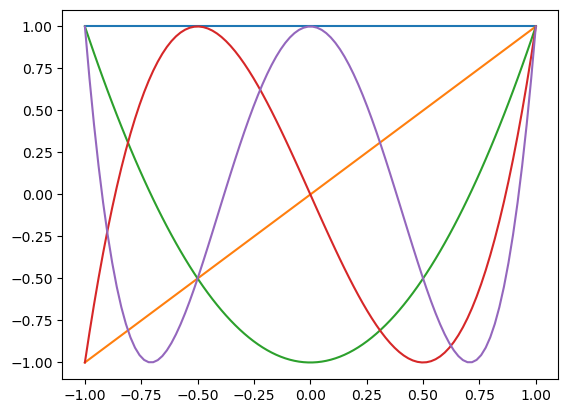

In [345]:
## confirm that chebyshev function works
for i in range(5):
    plt.plot(x, df_chebyshev[i])

## Function for Fitting

In [346]:
def fit_regression(x_train_features: Float[Tensor, "batch n_features"], y_train: Float[Tensor, "batch"], n_epochs: int = 1000, lr: float = 0.01, print_every: int = 1000):
    batch, n_features = x_train_features.shape

    model = LinReg(n_features)    
    optimizer = t.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    for i in range(n_epochs):
        optimizer.zero_grad()
        y_pred = model(x_train_features)[:, 0]
        calculate_loss = loss(y_pred, y_train)
        calculate_loss.backward()
        optimizer.step()

        if i % print_every == 0:
            print(f"Epoch {i}, Loss: {calculate_loss.item()}")

    return model, calculate_loss.item()

### Try for degree = 1

In [347]:
X_train = get_chebyshev_polynomial(x_train, degree = 1)
X = get_chebyshev_polynomial(x, degree = 1)

## remove 0th order
model, loss = fit_regression(X_train[:, 1:], y_train, n_epochs = 10000)

Epoch 0, Loss: 0.4631207585334778
Epoch 1000, Loss: 0.4589233994483948
Epoch 2000, Loss: 0.45892333984375
Epoch 3000, Loss: 0.45892333984375
Epoch 4000, Loss: 0.45892333984375
Epoch 5000, Loss: 0.45892333984375
Epoch 6000, Loss: 0.45892333984375
Epoch 7000, Loss: 0.45892333984375
Epoch 8000, Loss: 0.45892333984375
Epoch 9000, Loss: 0.45892333984375


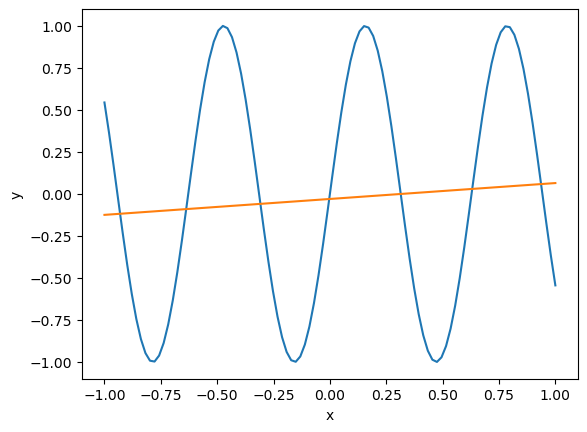

In [348]:
sns.lineplot(df_true, x ="x", y="y")
plt.plot(x.numpy(), model(X[:, 1:]).detach().numpy())

### Degree: 10

Epoch 0, Loss: 0.4631207585334778
Epoch 1000, Loss: 0.03382162004709244
Epoch 2000, Loss: 0.033812280744314194
Epoch 3000, Loss: 0.0338122732937336
Epoch 4000, Loss: 0.033812277019023895
Epoch 5000, Loss: 0.033812277019023895
Epoch 6000, Loss: 0.033812277019023895
Epoch 7000, Loss: 0.033812277019023895
Epoch 8000, Loss: 0.033812277019023895
Epoch 9000, Loss: 0.033812277019023895


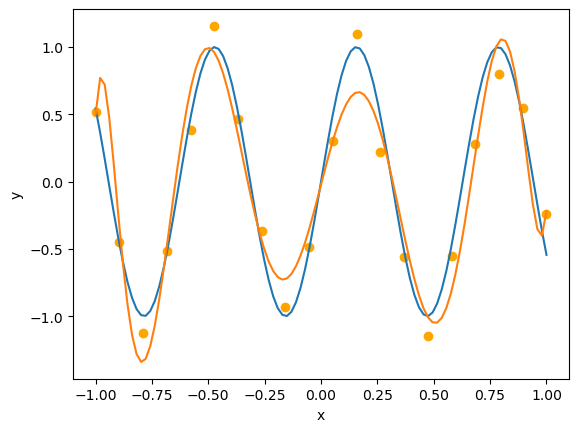

In [349]:
degree = 10
X_train = get_chebyshev_polynomial(x_train, degree = degree)
X = get_chebyshev_polynomial(x, degree = degree)

## remove 0th order
model, loss = fit_regression(X_train[:, 1:], y_train, n_epochs = 10000)

sns.lineplot(df_true, x ="x", y="y")
plt.scatter(df_train["x"], df_train["y"], c = "orange")
plt.plot(x.numpy(), model(X[:, 1:]).detach().numpy())

# 3: Run over various degrees (Replicate Double Descent)

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.49701088666915894
Epoch 10000, Loss: 0.49701088666915894
Epoch 15000, Loss: 0.49701088666915894
Epoch 20000, Loss: 0.49701088666915894
Epoch 25000, Loss: 0.49701088666915894
Epoch 30000, Loss: 0.49701088666915894
Epoch 35000, Loss: 0.49701088666915894
Epoch 40000, Loss: 0.49701088666915894
Epoch 45000, Loss: 0.49701088666915894


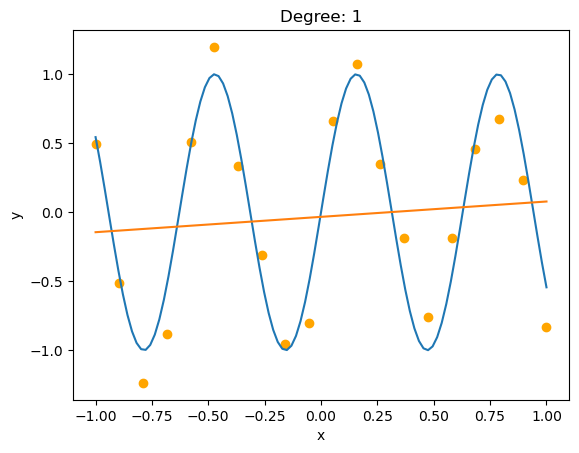

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.48796558380126953
Epoch 10000, Loss: 0.48796558380126953
Epoch 15000, Loss: 0.48796558380126953
Epoch 20000, Loss: 0.48796558380126953
Epoch 25000, Loss: 0.48796558380126953
Epoch 30000, Loss: 0.48796558380126953
Epoch 35000, Loss: 0.48796558380126953
Epoch 40000, Loss: 0.48796558380126953
Epoch 45000, Loss: 0.48796558380126953


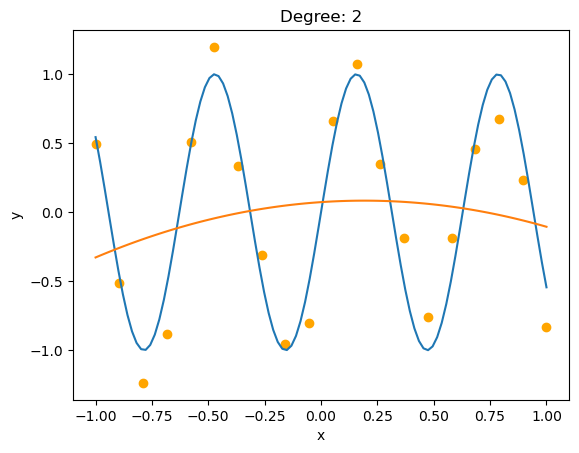

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.47985559701919556
Epoch 10000, Loss: 0.47985559701919556
Epoch 15000, Loss: 0.47985559701919556
Epoch 20000, Loss: 0.47985559701919556
Epoch 25000, Loss: 0.47985559701919556
Epoch 30000, Loss: 0.47985559701919556
Epoch 35000, Loss: 0.47985559701919556
Epoch 40000, Loss: 0.47985559701919556
Epoch 45000, Loss: 0.47985559701919556


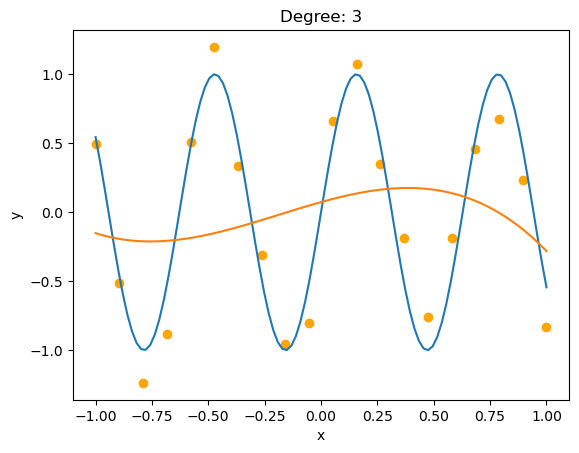

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.479820191860199
Epoch 10000, Loss: 0.479820191860199
Epoch 15000, Loss: 0.479820191860199
Epoch 20000, Loss: 0.479820191860199
Epoch 25000, Loss: 0.479820191860199
Epoch 30000, Loss: 0.479820191860199
Epoch 35000, Loss: 0.479820191860199
Epoch 40000, Loss: 0.479820191860199
Epoch 45000, Loss: 0.479820191860199


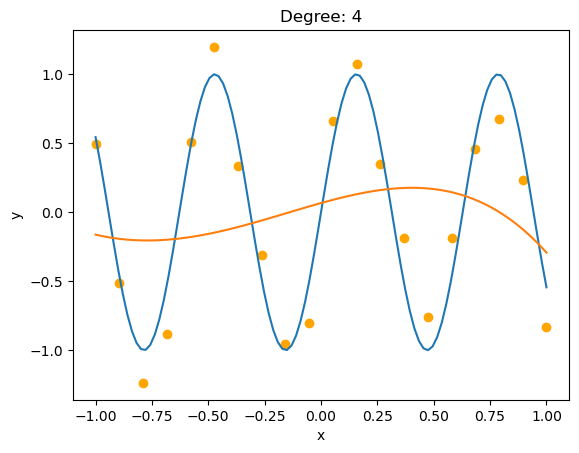

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.4041643738746643
Epoch 10000, Loss: 0.4041643738746643
Epoch 15000, Loss: 0.4041643738746643
Epoch 20000, Loss: 0.4041643738746643
Epoch 25000, Loss: 0.4041643738746643
Epoch 30000, Loss: 0.4041643738746643
Epoch 35000, Loss: 0.4041643738746643
Epoch 40000, Loss: 0.4041643738746643
Epoch 45000, Loss: 0.4041643738746643


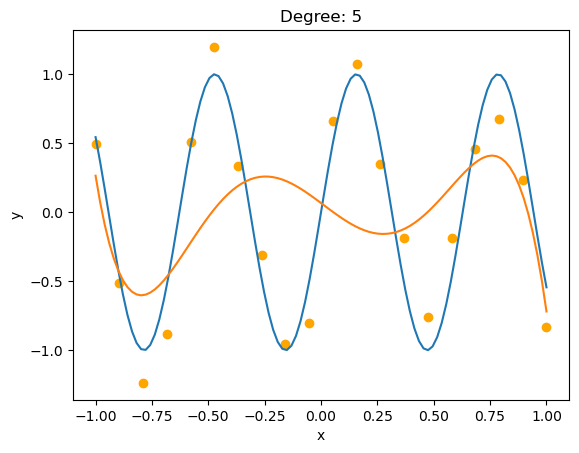

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.39672237634658813
Epoch 10000, Loss: 0.39672237634658813
Epoch 15000, Loss: 0.39672237634658813
Epoch 20000, Loss: 0.39672237634658813
Epoch 25000, Loss: 0.39672237634658813
Epoch 30000, Loss: 0.39672237634658813
Epoch 35000, Loss: 0.39672237634658813
Epoch 40000, Loss: 0.39672237634658813
Epoch 45000, Loss: 0.39672237634658813


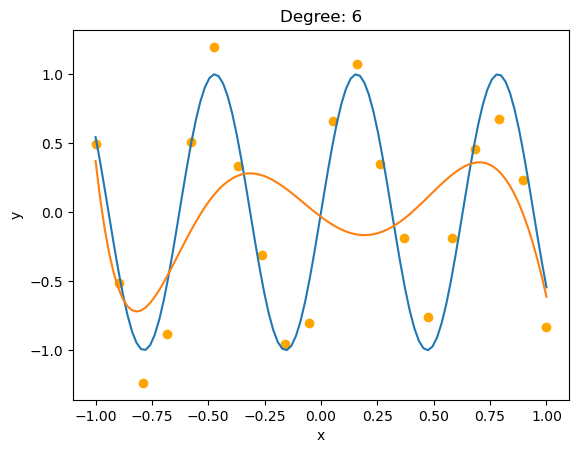

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.26156777143478394
Epoch 10000, Loss: 0.26156777143478394
Epoch 15000, Loss: 0.26156777143478394
Epoch 20000, Loss: 0.26156777143478394
Epoch 25000, Loss: 0.26156777143478394
Epoch 30000, Loss: 0.26156777143478394
Epoch 35000, Loss: 0.26156777143478394
Epoch 40000, Loss: 0.26156777143478394
Epoch 45000, Loss: 0.26156777143478394


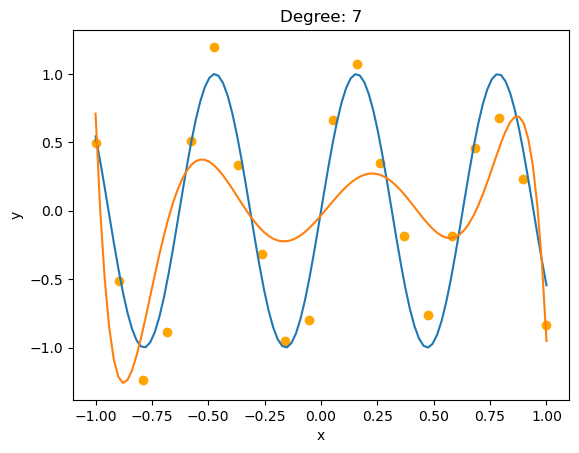

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.25874972343444824
Epoch 10000, Loss: 0.25874972343444824
Epoch 15000, Loss: 0.25874972343444824
Epoch 20000, Loss: 0.25874972343444824
Epoch 25000, Loss: 0.25874972343444824
Epoch 30000, Loss: 0.25874972343444824
Epoch 35000, Loss: 0.25874972343444824
Epoch 40000, Loss: 0.25874972343444824
Epoch 45000, Loss: 0.25874972343444824


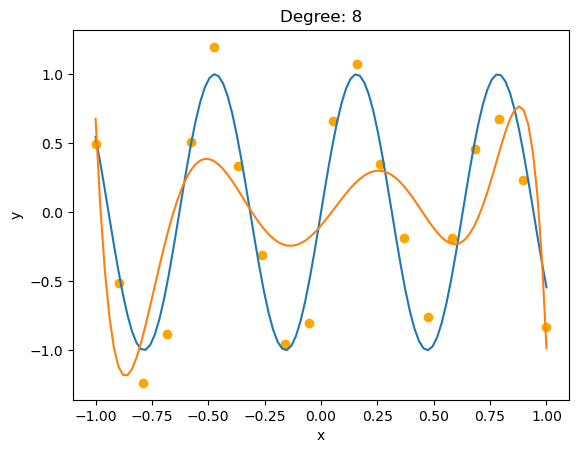

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.04988424479961395
Epoch 10000, Loss: 0.04988424479961395
Epoch 15000, Loss: 0.04988424479961395
Epoch 20000, Loss: 0.04988424479961395
Epoch 25000, Loss: 0.04988424479961395
Epoch 30000, Loss: 0.04988424479961395
Epoch 35000, Loss: 0.04988424479961395
Epoch 40000, Loss: 0.04988424479961395
Epoch 45000, Loss: 0.04988424479961395


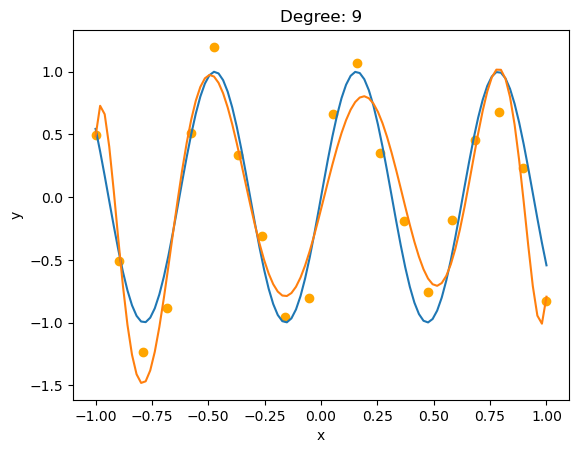

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.04671008884906769
Epoch 10000, Loss: 0.04671008884906769
Epoch 15000, Loss: 0.04671008884906769
Epoch 20000, Loss: 0.04671008884906769
Epoch 25000, Loss: 0.04671008884906769
Epoch 30000, Loss: 0.04671008884906769
Epoch 35000, Loss: 0.04671008884906769
Epoch 40000, Loss: 0.04671008884906769
Epoch 45000, Loss: 0.04671008884906769


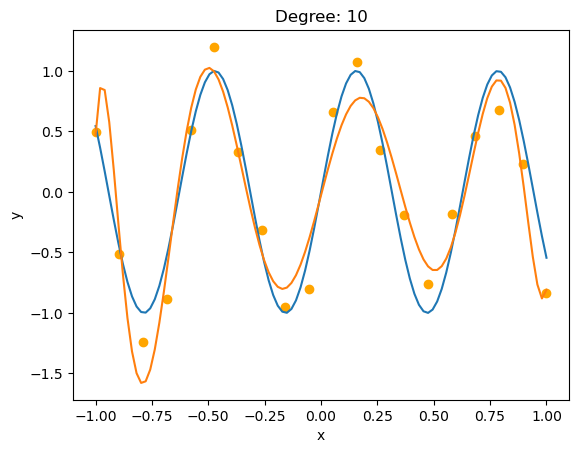

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.016176976263523102
Epoch 10000, Loss: 0.016176976263523102
Epoch 15000, Loss: 0.016176976263523102
Epoch 20000, Loss: 0.016176976263523102
Epoch 25000, Loss: 0.016176976263523102
Epoch 30000, Loss: 0.016176976263523102
Epoch 35000, Loss: 0.016176976263523102
Epoch 40000, Loss: 0.016176976263523102
Epoch 45000, Loss: 0.016176976263523102


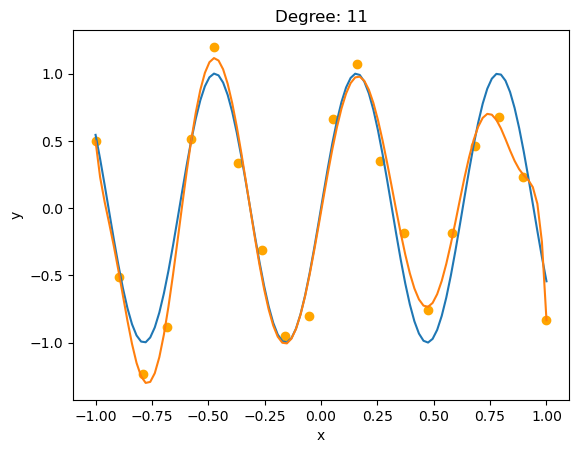

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.015897372737526894
Epoch 10000, Loss: 0.015897372737526894
Epoch 15000, Loss: 0.015897372737526894
Epoch 20000, Loss: 0.015897372737526894
Epoch 25000, Loss: 0.015897372737526894
Epoch 30000, Loss: 0.015897372737526894
Epoch 35000, Loss: 0.015897372737526894
Epoch 40000, Loss: 0.015897372737526894
Epoch 45000, Loss: 0.015897372737526894


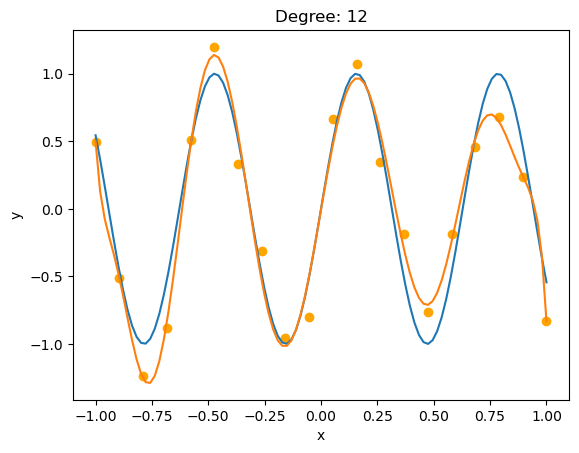

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.015546292066574097
Epoch 10000, Loss: 0.01554629486054182
Epoch 15000, Loss: 0.01554629486054182
Epoch 20000, Loss: 0.01554629486054182
Epoch 25000, Loss: 0.01554629486054182
Epoch 30000, Loss: 0.01554629486054182
Epoch 35000, Loss: 0.01554629486054182
Epoch 40000, Loss: 0.01554629486054182
Epoch 45000, Loss: 0.01554629486054182


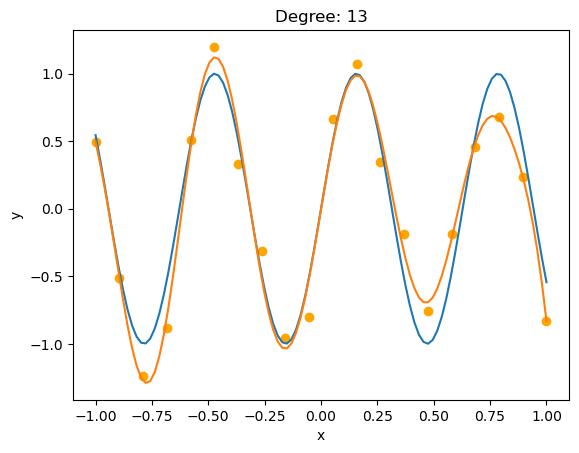

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.013935843482613564
Epoch 10000, Loss: 0.013933716341853142
Epoch 15000, Loss: 0.01393372006714344
Epoch 20000, Loss: 0.01393372006714344
Epoch 25000, Loss: 0.01393372006714344
Epoch 30000, Loss: 0.01393372006714344
Epoch 35000, Loss: 0.01393372006714344
Epoch 40000, Loss: 0.01393372006714344
Epoch 45000, Loss: 0.01393372006714344


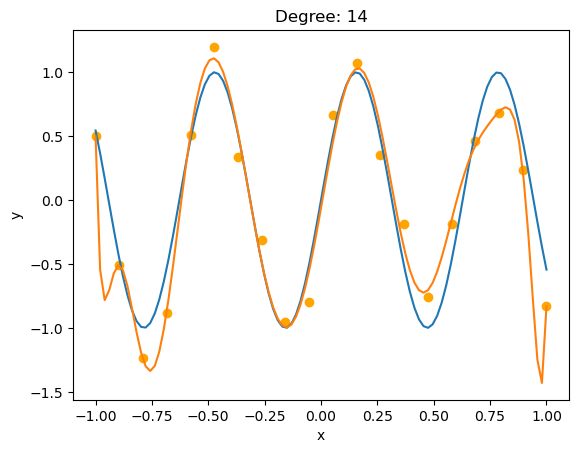

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.011727961711585522
Epoch 10000, Loss: 0.011376834474503994
Epoch 15000, Loss: 0.011283730156719685
Epoch 20000, Loss: 0.011258890852332115
Epoch 25000, Loss: 0.011252264492213726
Epoch 30000, Loss: 0.011250491254031658
Epoch 35000, Loss: 0.01125001348555088
Epoch 40000, Loss: 0.011249893344938755
Epoch 45000, Loss: 0.011249855160713196


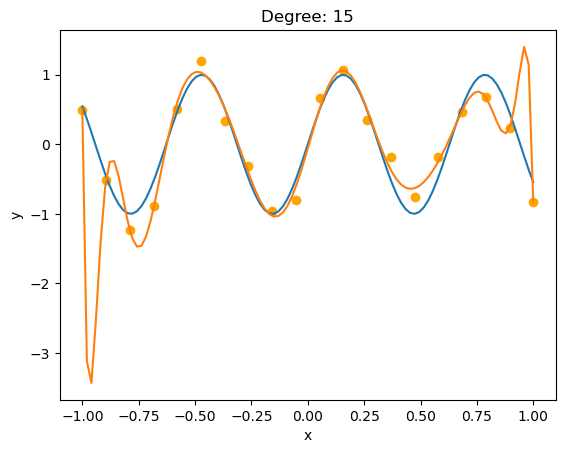

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.01154026947915554
Epoch 10000, Loss: 0.011182848364114761
Epoch 15000, Loss: 0.011083045043051243
Epoch 20000, Loss: 0.011052886955440044
Epoch 25000, Loss: 0.01104202400892973
Epoch 30000, Loss: 0.011036890558898449
Epoch 35000, Loss: 0.011033738031983376
Epoch 40000, Loss: 0.011031481437385082
Epoch 45000, Loss: 0.01102975569665432


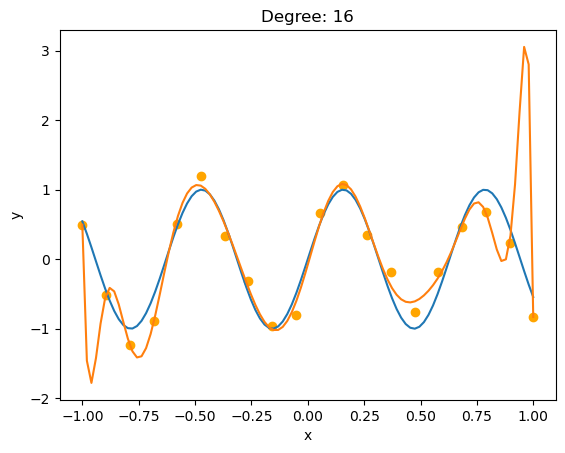

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.009562540799379349
Epoch 10000, Loss: 0.009345399215817451
Epoch 15000, Loss: 0.009134692139923573
Epoch 20000, Loss: 0.008929980918765068
Epoch 25000, Loss: 0.008730861358344555
Epoch 30000, Loss: 0.008537014946341515
Epoch 35000, Loss: 0.008348179049789906
Epoch 40000, Loss: 0.008164091035723686
Epoch 45000, Loss: 0.00798454787582159


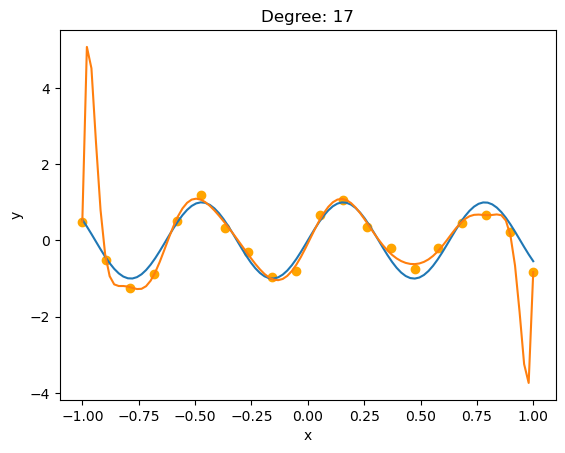

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.009506004862487316
Epoch 10000, Loss: 0.009297067299485207
Epoch 15000, Loss: 0.009092849679291248
Epoch 20000, Loss: 0.008893249556422234
Epoch 25000, Loss: 0.008698159828782082
Epoch 30000, Loss: 0.00850746501237154
Epoch 35000, Loss: 0.008321095257997513
Epoch 40000, Loss: 0.00813891552388668
Epoch 45000, Loss: 0.007960864342749119


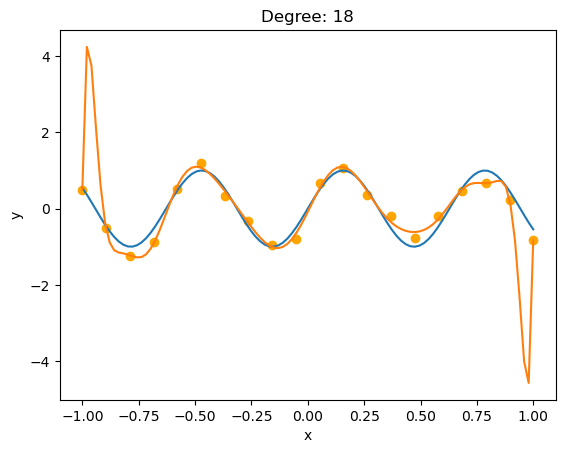

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.00018077620188705623
Epoch 10000, Loss: 0.00018006894970312715
Epoch 15000, Loss: 0.00017985457088798285
Epoch 20000, Loss: 0.00017964167636819184
Epoch 25000, Loss: 0.00017942821432370692
Epoch 30000, Loss: 0.00017921501421369612
Epoch 35000, Loss: 0.00017900248349178582
Epoch 40000, Loss: 0.00017878969083540142
Epoch 45000, Loss: 0.00017857721832115203


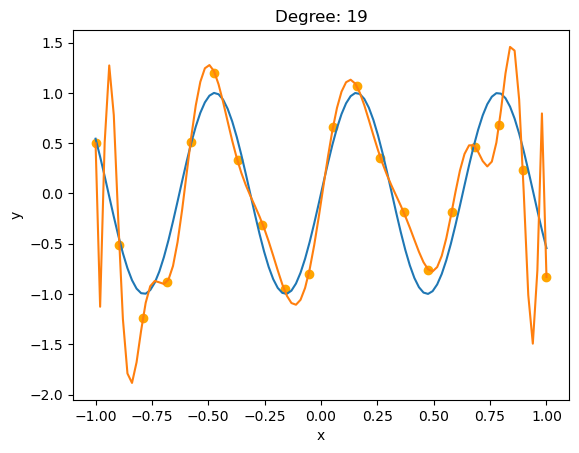

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 9.973446140065789e-05
Epoch 10000, Loss: 7.528909191023558e-05
Epoch 15000, Loss: 6.562300404766575e-05
Epoch 20000, Loss: 6.172093708300963e-05
Epoch 25000, Loss: 6.0144269809825346e-05
Epoch 30000, Loss: 5.9505749959498644e-05
Epoch 35000, Loss: 5.92463584325742e-05
Epoch 40000, Loss: 5.91394018556457e-05
Epoch 45000, Loss: 5.909453102503903e-05


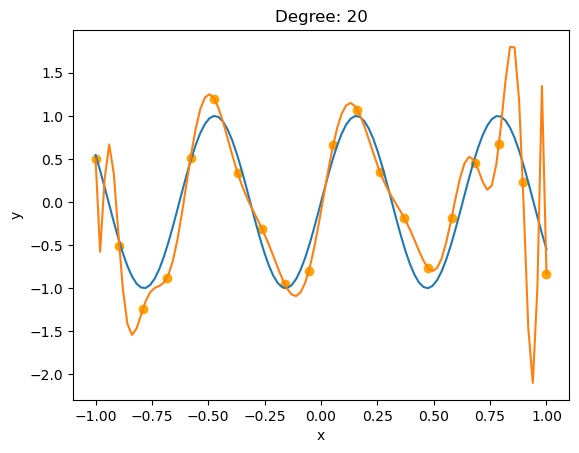

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 4.8366011469624937e-05
Epoch 10000, Loss: 2.4109211153700016e-05
Epoch 15000, Loss: 1.4152754374663346e-05
Epoch 20000, Loss: 9.971257895813324e-06
Epoch 25000, Loss: 8.126273314701393e-06
Epoch 30000, Loss: 7.2277834988199174e-06
Epoch 35000, Loss: 6.718976692354772e-06
Epoch 40000, Loss: 6.371683411998674e-06
Epoch 45000, Loss: 6.09503604209749e-06


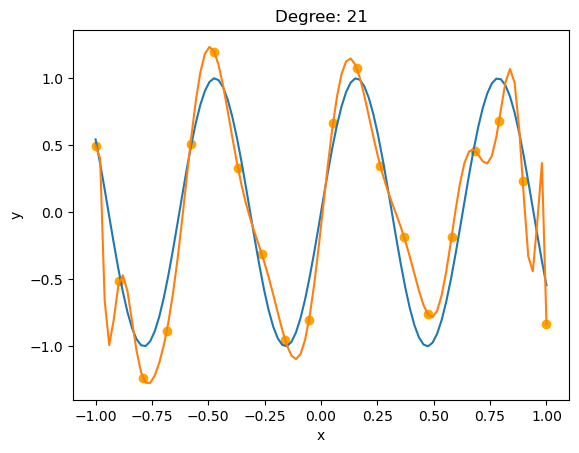

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 8.215307389036752e-06
Epoch 10000, Loss: 7.908269253675826e-06
Epoch 15000, Loss: 7.614996775373584e-06
Epoch 20000, Loss: 7.332576387852896e-06
Epoch 25000, Loss: 7.061062206048518e-06
Epoch 30000, Loss: 6.797641162847867e-06
Epoch 35000, Loss: 6.5452127273601945e-06
Epoch 40000, Loss: 6.301298526523169e-06
Epoch 45000, Loss: 6.0667216530418955e-06


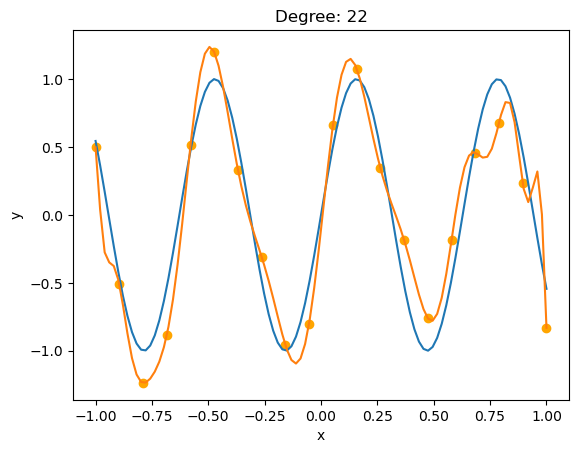

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 3.334159828227712e-06
Epoch 10000, Loss: 4.7255138468926816e-08
Epoch 15000, Loss: 6.763494209138798e-10
Epoch 20000, Loss: 1.583721001563454e-11
Epoch 25000, Loss: 5.0638382376178015e-12
Epoch 30000, Loss: 5.0650373652205705e-12
Epoch 35000, Loss: 5.0650373652205705e-12
Epoch 40000, Loss: 5.062772250041814e-12
Epoch 45000, Loss: 5.0650373652205705e-12


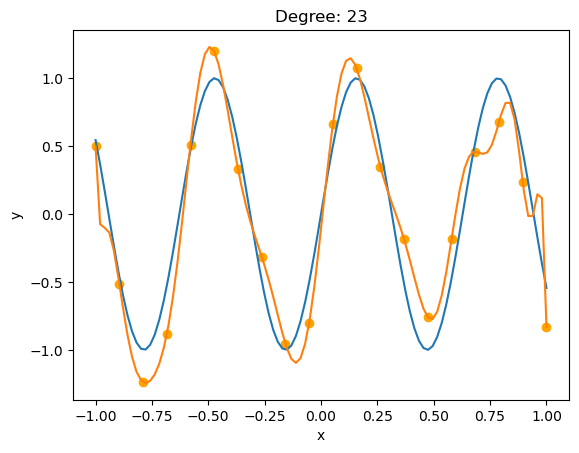

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 3.3340525078529026e-06
Epoch 10000, Loss: 4.7229615773858313e-08
Epoch 15000, Loss: 6.761592397097616e-10
Epoch 20000, Loss: 1.5767120248311173e-11
Epoch 25000, Loss: 4.810685270278947e-12
Epoch 30000, Loss: 4.810685270278947e-12
Epoch 35000, Loss: 4.810685270278947e-12
Epoch 40000, Loss: 4.810685270278947e-12
Epoch 45000, Loss: 4.810685270278947e-12


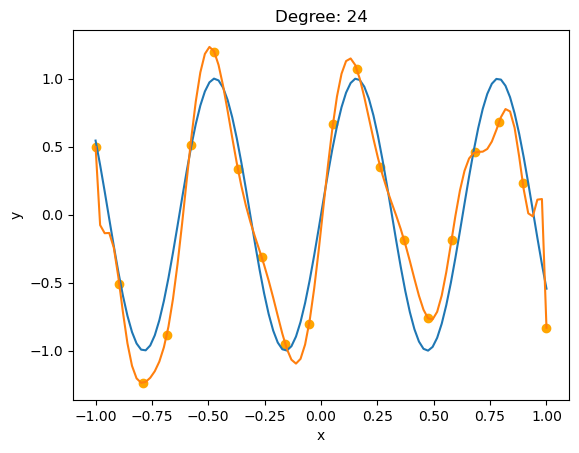

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 1.7865708370166933e-13
Epoch 10000, Loss: 1.7865708370166933e-13
Epoch 15000, Loss: 1.7865708370166933e-13
Epoch 20000, Loss: 1.7865708370166933e-13
Epoch 25000, Loss: 1.7865708370166933e-13
Epoch 30000, Loss: 1.7865708370166933e-13
Epoch 35000, Loss: 1.7865708370166933e-13
Epoch 40000, Loss: 1.7865708370166933e-13
Epoch 45000, Loss: 1.7865708370166933e-13


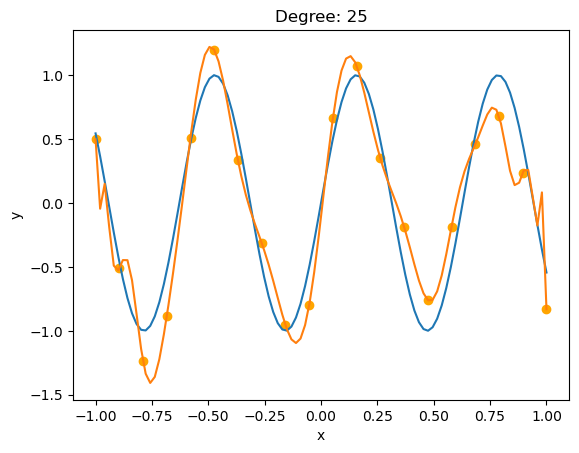

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 1.340816292629693e-13
Epoch 10000, Loss: 1.340816292629693e-13
Epoch 15000, Loss: 1.340816292629693e-13
Epoch 20000, Loss: 1.340816292629693e-13
Epoch 25000, Loss: 1.340816292629693e-13
Epoch 30000, Loss: 1.340816292629693e-13
Epoch 35000, Loss: 1.340816292629693e-13
Epoch 40000, Loss: 1.340816292629693e-13
Epoch 45000, Loss: 1.340816292629693e-13


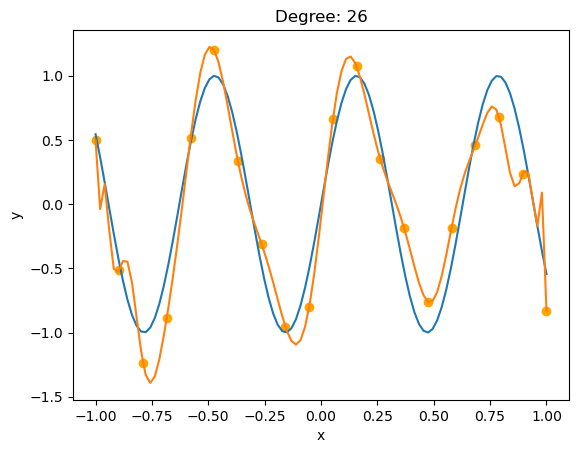

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 9.575673587391975e-14
Epoch 10000, Loss: 9.575673587391975e-14
Epoch 15000, Loss: 9.575673587391975e-14
Epoch 20000, Loss: 9.575673587391975e-14
Epoch 25000, Loss: 9.575673587391975e-14
Epoch 30000, Loss: 9.575673587391975e-14
Epoch 35000, Loss: 9.575673587391975e-14
Epoch 40000, Loss: 9.575673587391975e-14
Epoch 45000, Loss: 9.575673587391975e-14


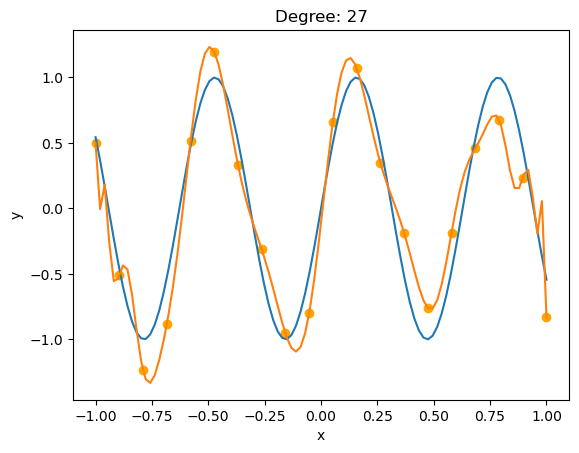

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 8.484324489710718e-14
Epoch 10000, Loss: 8.58202398035246e-14
Epoch 15000, Loss: 8.58202398035246e-14
Epoch 20000, Loss: 8.351097726755699e-14
Epoch 25000, Loss: 8.653078524979013e-14
Epoch 30000, Loss: 8.346656563606655e-14
Epoch 35000, Loss: 8.506528950203221e-14
Epoch 40000, Loss: 8.506528950203221e-14
Epoch 45000, Loss: 8.204548151979907e-14


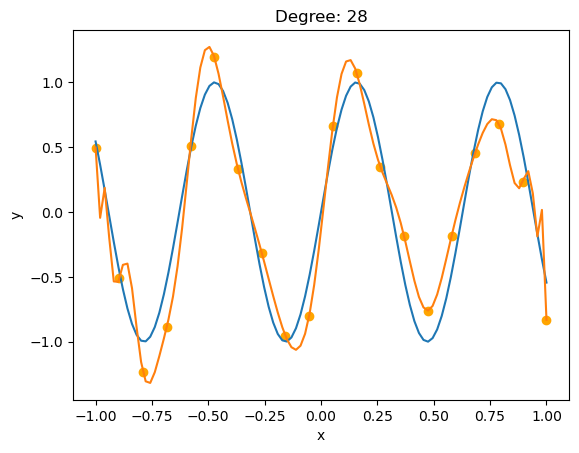

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 7.244205235679146e-14
Epoch 10000, Loss: 7.244205235679146e-14
Epoch 15000, Loss: 7.244205235679146e-14
Epoch 20000, Loss: 7.244205235679146e-14
Epoch 25000, Loss: 7.244205235679146e-14
Epoch 30000, Loss: 7.244205235679146e-14
Epoch 35000, Loss: 7.244205235679146e-14
Epoch 40000, Loss: 7.244205235679146e-14
Epoch 45000, Loss: 7.244205235679146e-14


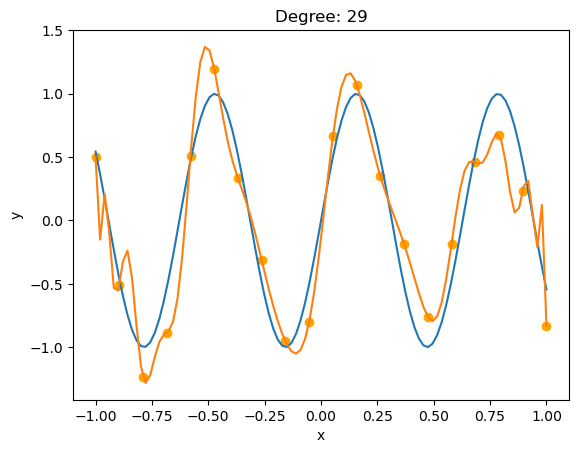

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 7.017719467605071e-14
Epoch 10000, Loss: 7.017719467605071e-14
Epoch 15000, Loss: 7.017719467605071e-14
Epoch 20000, Loss: 7.017719467605071e-14
Epoch 25000, Loss: 7.017719467605071e-14
Epoch 30000, Loss: 7.017719467605071e-14
Epoch 35000, Loss: 7.017719467605071e-14
Epoch 40000, Loss: 7.017719467605071e-14
Epoch 45000, Loss: 7.017719467605071e-14


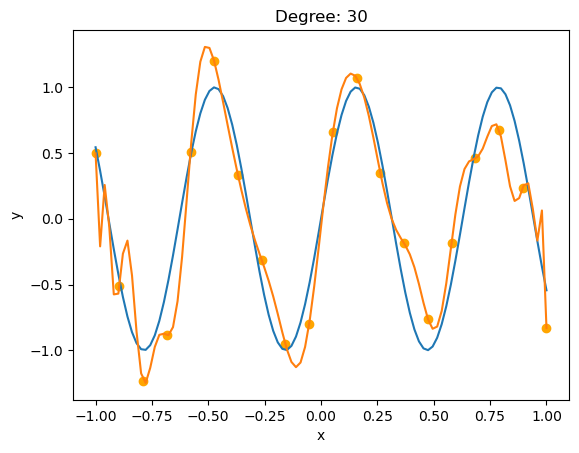

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 5.815348067461298e-14
Epoch 10000, Loss: 5.815348067461298e-14
Epoch 15000, Loss: 5.815348067461298e-14
Epoch 20000, Loss: 5.815348067461298e-14
Epoch 25000, Loss: 5.815348067461298e-14
Epoch 30000, Loss: 5.815348067461298e-14
Epoch 35000, Loss: 5.815348067461298e-14
Epoch 40000, Loss: 5.815348067461298e-14
Epoch 45000, Loss: 5.815348067461298e-14


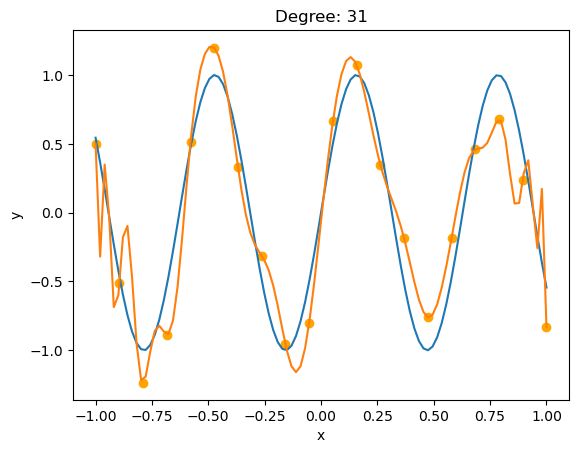

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 5.5844218138645374e-14
Epoch 10000, Loss: 4.1000534944154315e-14
Epoch 15000, Loss: 3.784750223184523e-14
Epoch 20000, Loss: 4.22328831791146e-14
Epoch 25000, Loss: 4.116706839784809e-14
Epoch 30000, Loss: 4.2765792263813746e-14
Epoch 35000, Loss: 4.2765792263813746e-14
Epoch 40000, Loss: 4.22328831791146e-14
Epoch 45000, Loss: 4.116706839784809e-14


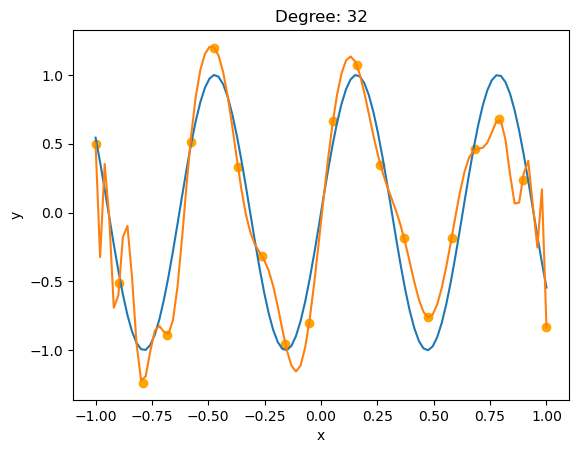

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 2.2382096854069514e-14
Epoch 10000, Loss: 2.2382096854069514e-14
Epoch 15000, Loss: 2.2382096854069514e-14
Epoch 20000, Loss: 2.2382096854069514e-14
Epoch 25000, Loss: 2.2382096854069514e-14
Epoch 30000, Loss: 2.2382096854069514e-14
Epoch 35000, Loss: 2.2382096854069514e-14
Epoch 40000, Loss: 2.2382096854069514e-14
Epoch 45000, Loss: 2.2382096854069514e-14


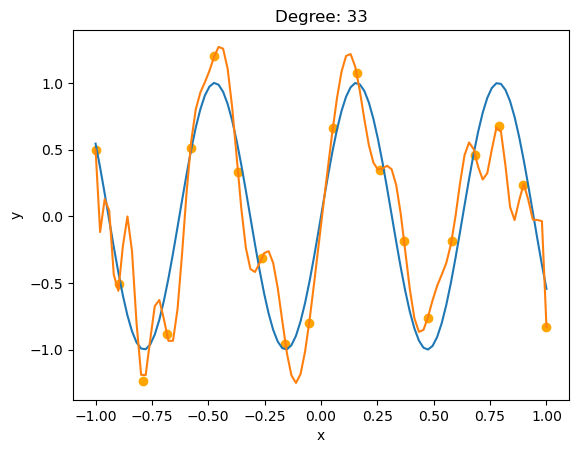

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 2.8965718034843976e-14
Epoch 10000, Loss: 2.8965718034843976e-14
Epoch 15000, Loss: 2.8965718034843976e-14
Epoch 20000, Loss: 2.8965718034843976e-14
Epoch 25000, Loss: 2.8965718034843976e-14
Epoch 30000, Loss: 2.8965718034843976e-14
Epoch 35000, Loss: 2.8965718034843976e-14
Epoch 40000, Loss: 2.8965718034843976e-14
Epoch 45000, Loss: 2.8965718034843976e-14


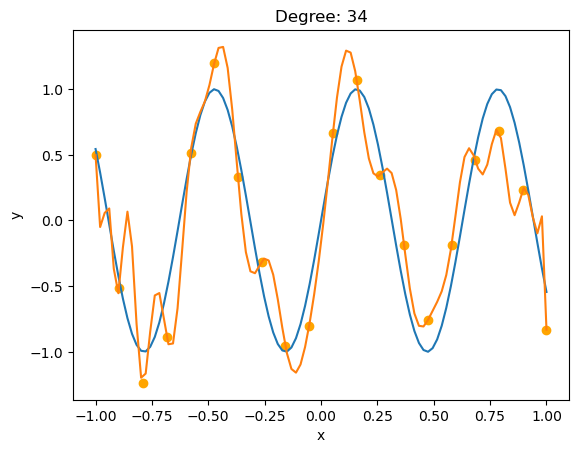

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 6.377121324497442e-14
Epoch 10000, Loss: 6.377121324497442e-14
Epoch 15000, Loss: 6.377121324497442e-14
Epoch 20000, Loss: 6.377121324497442e-14
Epoch 25000, Loss: 6.377121324497442e-14
Epoch 30000, Loss: 6.377121324497442e-14
Epoch 35000, Loss: 6.377121324497442e-14
Epoch 40000, Loss: 6.377121324497442e-14
Epoch 45000, Loss: 6.377121324497442e-14


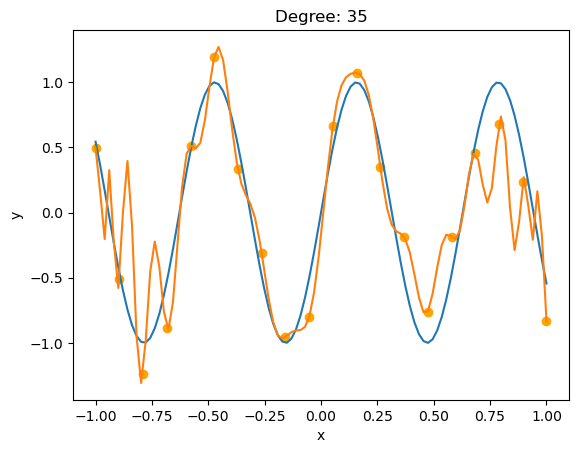

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 5.5788706987414116e-14
Epoch 10000, Loss: 5.5788706987414116e-14
Epoch 15000, Loss: 5.5788706987414116e-14
Epoch 20000, Loss: 5.5788706987414116e-14
Epoch 25000, Loss: 5.5788706987414116e-14
Epoch 30000, Loss: 5.5788706987414116e-14
Epoch 35000, Loss: 5.5788706987414116e-14
Epoch 40000, Loss: 5.5788706987414116e-14
Epoch 45000, Loss: 5.5788706987414116e-14


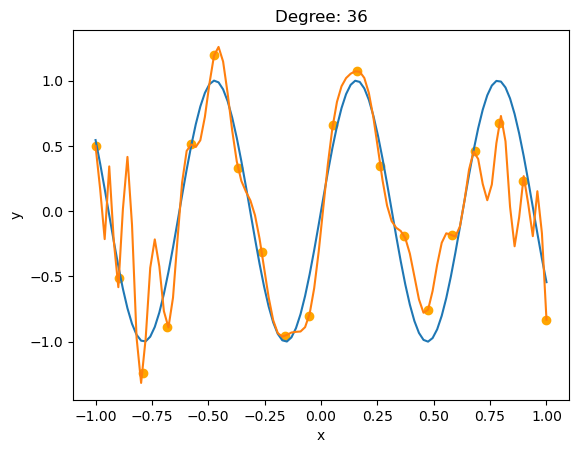

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 2.091660110631159e-14
Epoch 10000, Loss: 2.091660110631159e-14
Epoch 15000, Loss: 2.091660110631159e-14
Epoch 20000, Loss: 2.091660110631159e-14
Epoch 25000, Loss: 2.091660110631159e-14
Epoch 30000, Loss: 2.091660110631159e-14
Epoch 35000, Loss: 2.091660110631159e-14
Epoch 40000, Loss: 2.091660110631159e-14
Epoch 45000, Loss: 2.091660110631159e-14


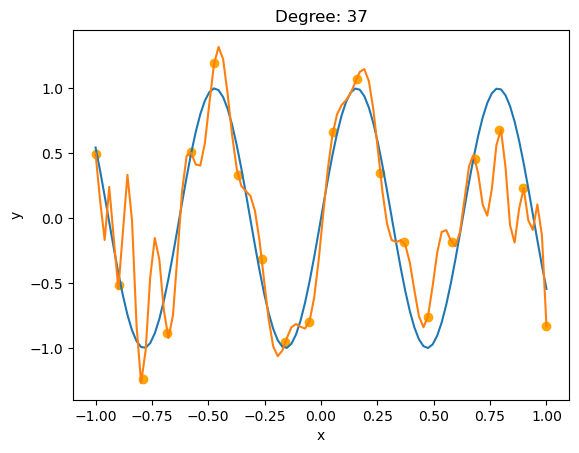

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 1.6076029735385446e-14
Epoch 10000, Loss: 4.2632565839671906e-15
Epoch 15000, Loss: 4.2632565839671906e-15
Epoch 20000, Loss: 4.2632565839671906e-15
Epoch 25000, Loss: 4.2632565839671906e-15
Epoch 30000, Loss: 4.2632565839671906e-15
Epoch 35000, Loss: 4.2632565839671906e-15
Epoch 40000, Loss: 4.2632565839671906e-15
Epoch 45000, Loss: 4.2632565839671906e-15


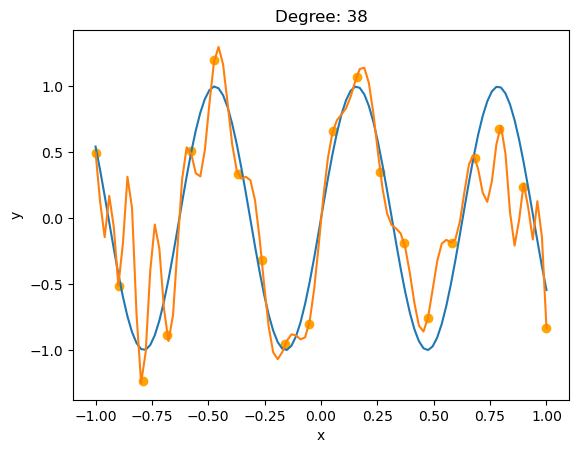

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 6.761258389373793e-15
Epoch 10000, Loss: 2.3536728969086266e-15
Epoch 15000, Loss: 4.440892098500626e-16
Epoch 20000, Loss: 4.440892098500626e-16
Epoch 25000, Loss: 4.440892098500626e-16
Epoch 30000, Loss: 4.440892098500626e-16
Epoch 35000, Loss: 4.440892098500626e-16
Epoch 40000, Loss: 4.440892098500626e-16
Epoch 45000, Loss: 4.440892098500626e-16


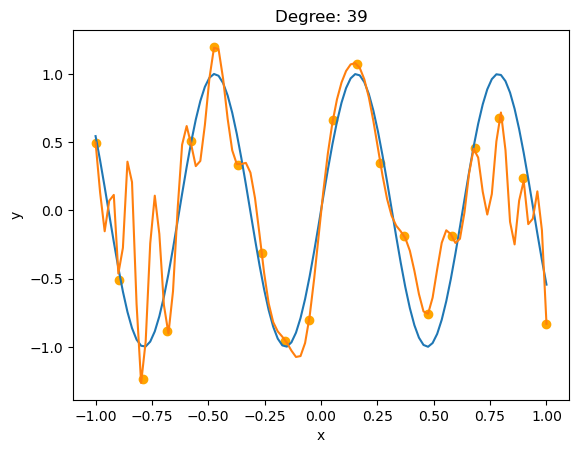

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 3.1497028563868407e-14
Epoch 10000, Loss: 3.1497028563868407e-14
Epoch 15000, Loss: 3.1497028563868407e-14
Epoch 20000, Loss: 3.1497028563868407e-14
Epoch 25000, Loss: 3.1497028563868407e-14
Epoch 30000, Loss: 3.1497028563868407e-14
Epoch 35000, Loss: 3.1497028563868407e-14
Epoch 40000, Loss: 3.1497028563868407e-14
Epoch 45000, Loss: 3.1497028563868407e-14


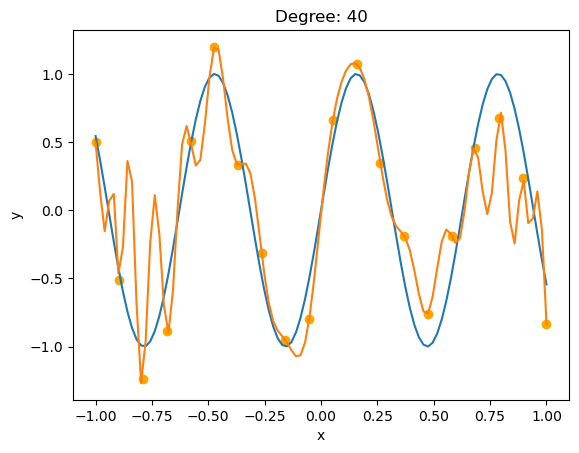

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 2.4513724722536635e-14
Epoch 10000, Loss: 1.1934897514720433e-14
Epoch 15000, Loss: 1.5432100042289676e-14
Epoch 20000, Loss: 2.0516921833886072e-14
Epoch 25000, Loss: 2.0516921833886072e-14
Epoch 30000, Loss: 2.0516921833886072e-14
Epoch 35000, Loss: 2.0516921833886072e-14
Epoch 40000, Loss: 2.0516921833886072e-14
Epoch 45000, Loss: 2.0516921833886072e-14


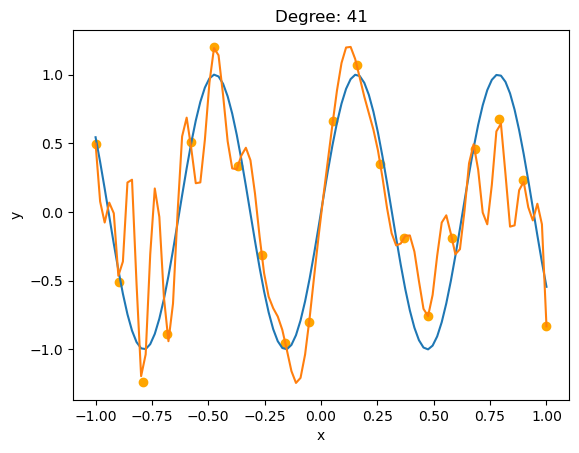

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 3.415046091509617e-14
Epoch 10000, Loss: 3.415046091509617e-14
Epoch 15000, Loss: 3.415046091509617e-14
Epoch 20000, Loss: 3.415046091509617e-14
Epoch 25000, Loss: 3.415046091509617e-14
Epoch 30000, Loss: 3.415046091509617e-14
Epoch 35000, Loss: 3.415046091509617e-14
Epoch 40000, Loss: 3.415046091509617e-14
Epoch 45000, Loss: 3.415046091509617e-14


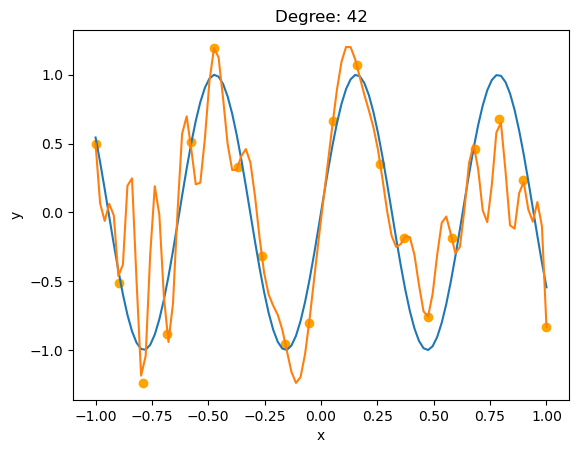

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 2.2448709219107486e-14
Epoch 10000, Loss: 2.0095036745715333e-14
Epoch 15000, Loss: 1.709743457922741e-14
Epoch 20000, Loss: 1.3289369265949945e-14
Epoch 25000, Loss: 1.0791367460543343e-14
Epoch 30000, Loss: 1.2012612787631015e-14
Epoch 35000, Loss: 1.2967405266435007e-14
Epoch 40000, Loss: 1.2967405266435007e-14
Epoch 45000, Loss: 1.2967405266435007e-14


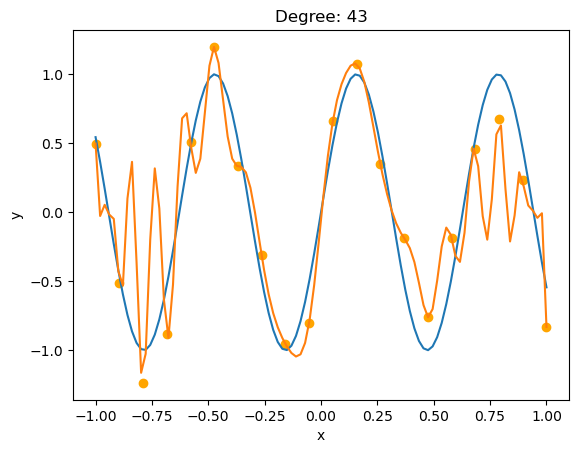

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 2.2548630307763287e-14
Epoch 10000, Loss: 1.5698552890573356e-14
Epoch 15000, Loss: 1.733058209202505e-14
Epoch 20000, Loss: 1.746380851616689e-14
Epoch 25000, Loss: 1.5254463680723293e-14
Epoch 30000, Loss: 1.5132340164454063e-14
Epoch 35000, Loss: 1.4721557984155934e-14
Epoch 40000, Loss: 1.7574830818629407e-14
Epoch 45000, Loss: 1.2712053631958042e-14


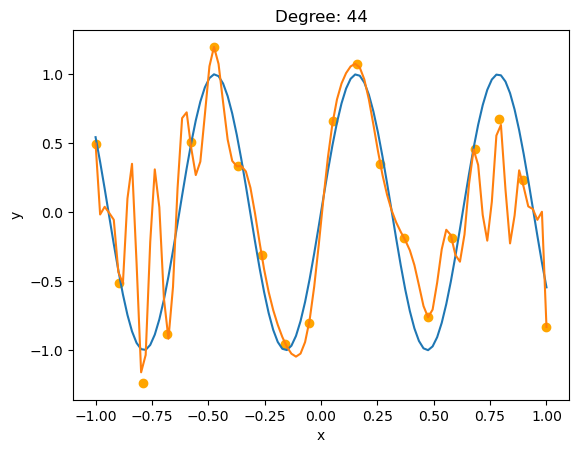

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 2.425837308805967e-14
Epoch 10000, Loss: 2.425837308805967e-14
Epoch 15000, Loss: 2.425837308805967e-14
Epoch 20000, Loss: 2.425837308805967e-14
Epoch 25000, Loss: 2.425837308805967e-14
Epoch 30000, Loss: 2.425837308805967e-14
Epoch 35000, Loss: 2.425837308805967e-14
Epoch 40000, Loss: 2.425837308805967e-14
Epoch 45000, Loss: 2.425837308805967e-14


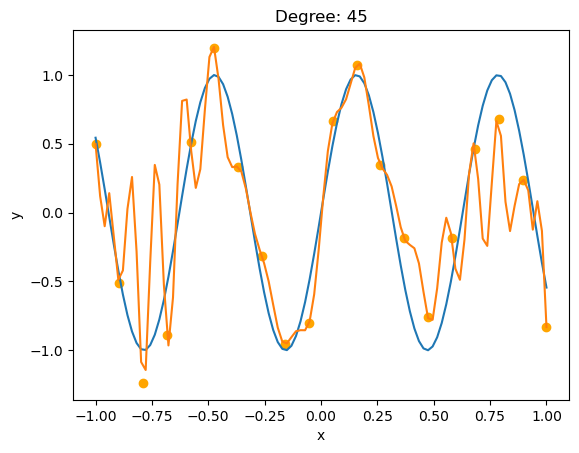

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 1.746380851616689e-14
Epoch 10000, Loss: 6.439293542825908e-15
Epoch 15000, Loss: 7.949196686909531e-15
Epoch 20000, Loss: 7.949196686909531e-15
Epoch 25000, Loss: 7.949196686909531e-15
Epoch 30000, Loss: 7.949196686909531e-15
Epoch 35000, Loss: 7.949196686909531e-15
Epoch 40000, Loss: 7.949196686909531e-15
Epoch 45000, Loss: 7.949196686909531e-15


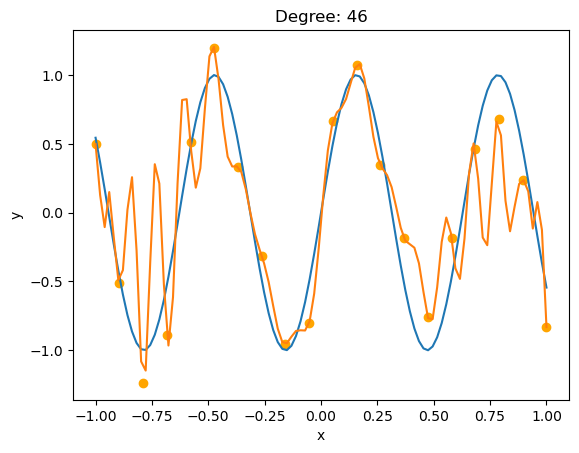

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 8.493206138382448e-15
Epoch 10000, Loss: 7.172040569671922e-15
Epoch 15000, Loss: 7.172040569671922e-15
Epoch 20000, Loss: 7.172040569671922e-15
Epoch 25000, Loss: 7.172040569671922e-15
Epoch 30000, Loss: 7.172040569671922e-15
Epoch 35000, Loss: 7.172040569671922e-15
Epoch 40000, Loss: 7.172040569671922e-15
Epoch 45000, Loss: 7.172040569671922e-15


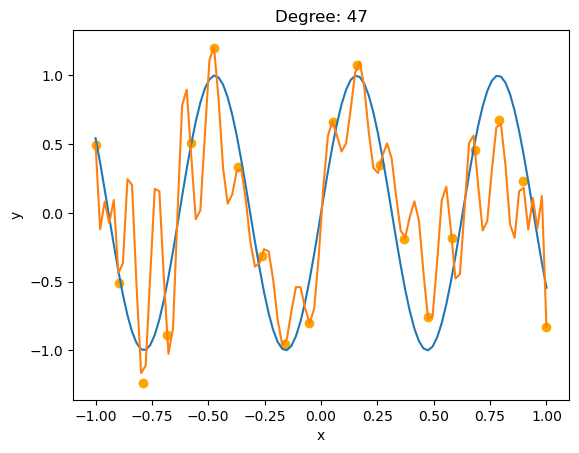

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 1.0946798853397454e-14
Epoch 10000, Loss: 2.264854927883672e-15
Epoch 15000, Loss: 4.707345793817253e-15
Epoch 20000, Loss: 4.707345793817253e-15
Epoch 25000, Loss: 4.707345793817253e-15
Epoch 30000, Loss: 4.707345793817253e-15
Epoch 35000, Loss: 4.707345793817253e-15
Epoch 40000, Loss: 4.707345793817253e-15
Epoch 45000, Loss: 4.707345793817253e-15


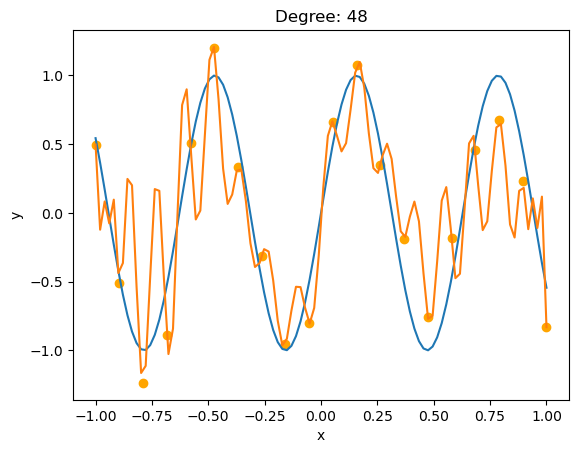

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 7.560618628290727e-15
Epoch 10000, Loss: 5.739853122015354e-15
Epoch 15000, Loss: 4.0190074338463614e-15
Epoch 20000, Loss: 4.796163551083971e-15
Epoch 25000, Loss: 5.329070518200751e-15
Epoch 30000, Loss: 6.050715484207103e-15
Epoch 35000, Loss: 5.440092820663267e-15
Epoch 40000, Loss: 5.495603971894525e-15
Epoch 45000, Loss: 5.828670879282072e-15


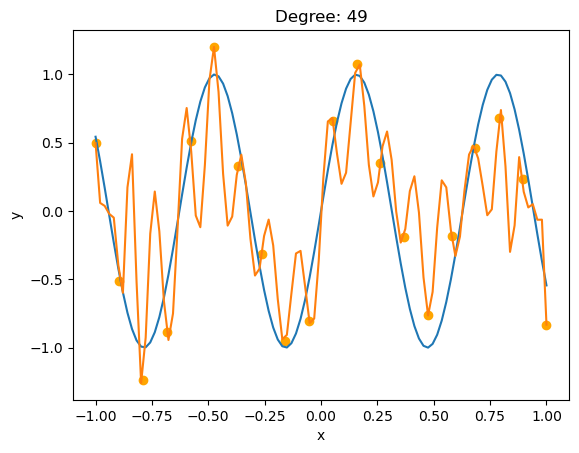

In [451]:
degrees = list(range(1, 50))
model_list = []
train_loss_list = []
test_loss_list = []

for degree in degrees:
    X_train = get_chebyshev_polynomial(x_train, degree = degree)
    X = get_chebyshev_polynomial(x, degree = degree)
    X_test = get_chebyshev_polynomial(x_test, degree = degree)
    
    ## remove 0th order
    model, loss = fit_regression(X_train[:, 1:], y_train, n_epochs = 50000, lr = 0.05, print_every = 5000)
    model_list.append(model)
    train_loss_list.append(loss)

    ## test set loss
    with t.inference_mode():
        loss = nn.MSELoss()
        y_pred = model(X_test[:, 1:])[:, 0]
        calculate_loss = loss(y_pred, y_test)
        test_loss_list.append(calculate_loss.item())
    
    sns.lineplot(df_true, x ="x", y="y")
    plt.title(f"Degree: {degree}")
    plt.scatter(df_train["x"], df_train["y"], c = "orange")
    plt.plot(x.numpy(), model(X[:, 1:]).detach().numpy())
    plt.show()
    

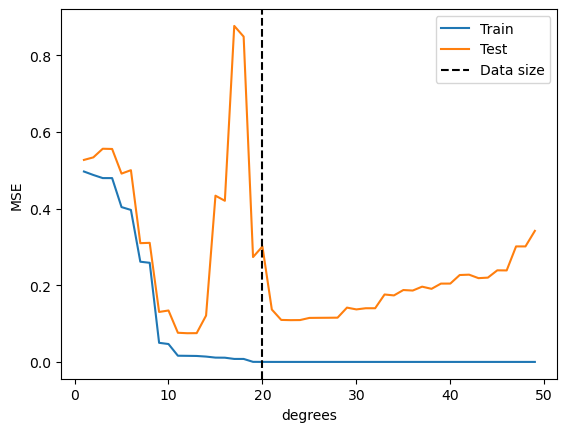

In [434]:
plt.plot(degrees, train_loss_list, label='Train')
plt.plot(degrees, test_loss_list, label='Test')
plt.axvline(x = 20, ls = '--', label = "Data size", c = "black")
plt.legend()
plt.xlabel("degrees")
plt.ylabel("MSE")
plt.show()


In [491]:
mean_weight_list = []

for model in model_list:
    weight = model.linear.weight
    mean_weight_list.append(weight.abs().mean().item())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


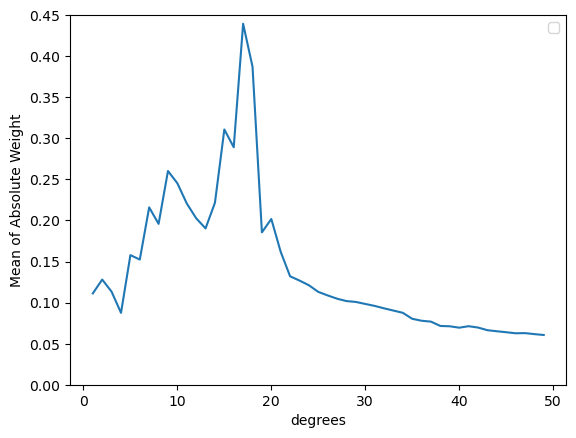

In [493]:
degrees = list(range(1, 50))

plt.plot(degrees, mean_weight_list)
plt.legend()
plt.ylim(0.0, 0.45)

plt.xlabel("degrees")
plt.ylabel("Mean of Absolute Weight")
plt.show()

# 4: Fix Double Descent

regularization is known to fix overfitting so likely will fix this as well

In [475]:
def fit_regression_L2(x_train_features: Float[Tensor, "batch n_features"], y_train: Float[Tensor, "batch"], n_epochs: int = 1000, 
                   lr: float = 0.01, print_every: int = 1000, regularization_constant: float = 0.1):
    batch, n_features = x_train_features.shape

    model = LinReg(n_features)    
    optimizer = t.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    for i in range(n_epochs):
        optimizer.zero_grad()
        y_pred = model(x_train_features)[:, 0]
        calculate_loss = loss(y_pred, y_train) + regularization_constant * model.linear.weight.pow(2).sum()
        calculate_loss.backward()
        optimizer.step()

        if i % print_every == 0:
            print(f"Epoch {i}, Loss: {calculate_loss.item()}")

    return model, loss(y_pred, y_train).item()

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.4979831576347351
Epoch 10000, Loss: 0.4979831576347351
Epoch 15000, Loss: 0.4979831576347351
Epoch 20000, Loss: 0.4979831576347351
Epoch 25000, Loss: 0.4979831576347351
Epoch 30000, Loss: 0.4979831576347351
Epoch 35000, Loss: 0.4979831576347351
Epoch 40000, Loss: 0.4979831576347351
Epoch 45000, Loss: 0.4979831576347351


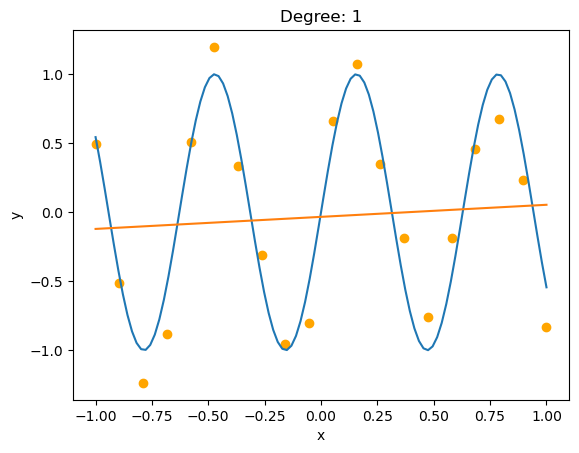

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.42084431648254395
Epoch 10000, Loss: 0.42084431648254395
Epoch 15000, Loss: 0.42084431648254395
Epoch 20000, Loss: 0.42084431648254395
Epoch 25000, Loss: 0.42084431648254395
Epoch 30000, Loss: 0.42084431648254395
Epoch 35000, Loss: 0.42084431648254395
Epoch 40000, Loss: 0.42084431648254395
Epoch 45000, Loss: 0.42084431648254395


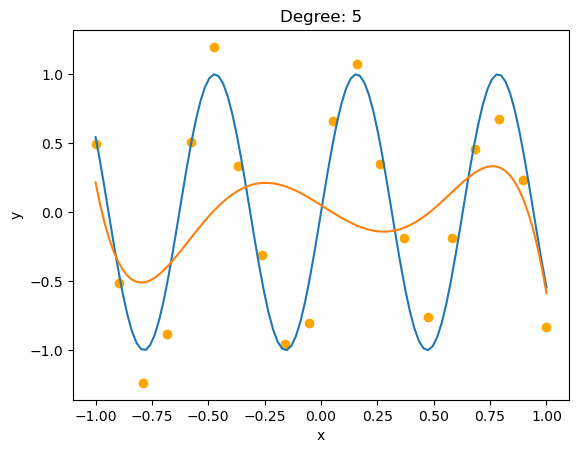

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.1322106271982193
Epoch 10000, Loss: 0.1322106271982193
Epoch 15000, Loss: 0.1322106271982193
Epoch 20000, Loss: 0.1322106271982193
Epoch 25000, Loss: 0.1322106271982193
Epoch 30000, Loss: 0.1322106271982193
Epoch 35000, Loss: 0.1322106271982193
Epoch 40000, Loss: 0.1322106271982193
Epoch 45000, Loss: 0.1322106271982193


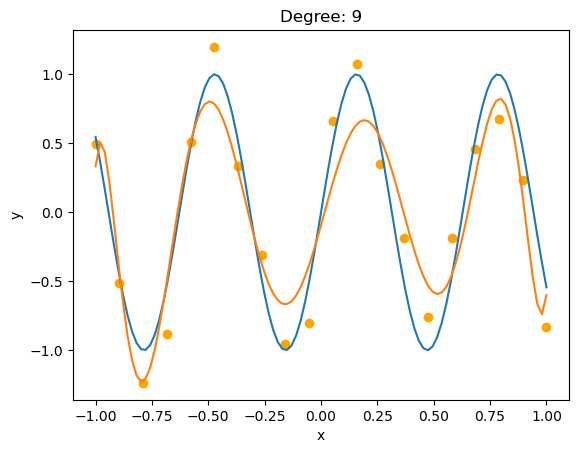

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.08527784794569016
Epoch 10000, Loss: 0.08527784794569016
Epoch 15000, Loss: 0.08527784794569016
Epoch 20000, Loss: 0.08527784794569016
Epoch 25000, Loss: 0.08527784794569016
Epoch 30000, Loss: 0.08527784794569016
Epoch 35000, Loss: 0.08527784794569016
Epoch 40000, Loss: 0.08527784794569016
Epoch 45000, Loss: 0.08527784794569016


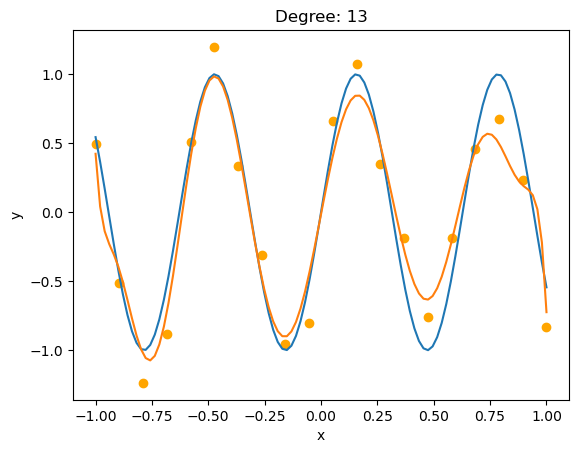

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.08034685999155045
Epoch 10000, Loss: 0.08034685999155045
Epoch 15000, Loss: 0.08034685999155045
Epoch 20000, Loss: 0.08034685999155045
Epoch 25000, Loss: 0.08034685999155045
Epoch 30000, Loss: 0.08034685999155045
Epoch 35000, Loss: 0.08034685999155045
Epoch 40000, Loss: 0.08034685999155045
Epoch 45000, Loss: 0.08034685999155045


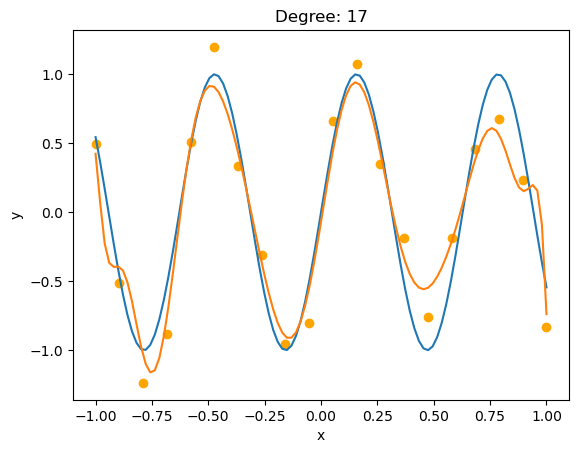

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.07222752273082733
Epoch 10000, Loss: 0.07222752273082733
Epoch 15000, Loss: 0.07222752273082733
Epoch 20000, Loss: 0.07222752273082733
Epoch 25000, Loss: 0.07222752273082733
Epoch 30000, Loss: 0.07222752273082733
Epoch 35000, Loss: 0.07222752273082733
Epoch 40000, Loss: 0.07222752273082733
Epoch 45000, Loss: 0.07222752273082733


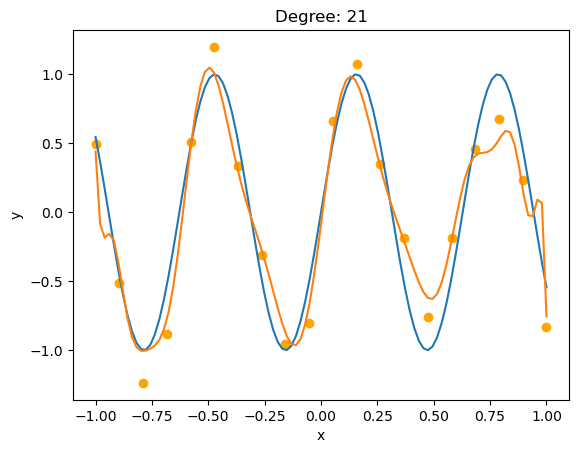

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.06643572449684143
Epoch 10000, Loss: 0.06643572449684143
Epoch 15000, Loss: 0.06643572449684143
Epoch 20000, Loss: 0.06643572449684143
Epoch 25000, Loss: 0.06643572449684143
Epoch 30000, Loss: 0.06643572449684143
Epoch 35000, Loss: 0.06643572449684143
Epoch 40000, Loss: 0.06643572449684143
Epoch 45000, Loss: 0.06643572449684143


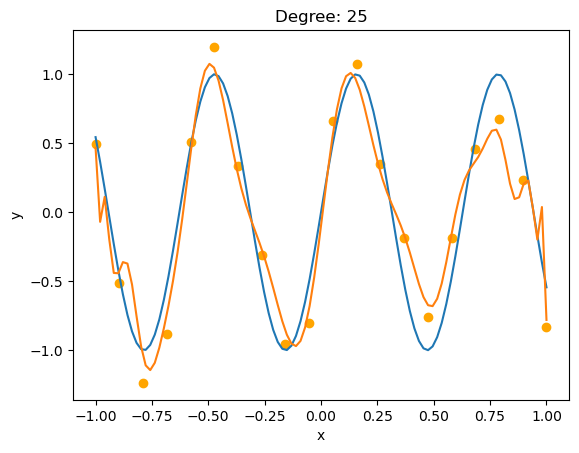

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.06533684581518173
Epoch 10000, Loss: 0.06533684581518173
Epoch 15000, Loss: 0.06533684581518173
Epoch 20000, Loss: 0.06533684581518173
Epoch 25000, Loss: 0.06533684581518173
Epoch 30000, Loss: 0.06533684581518173
Epoch 35000, Loss: 0.06533684581518173
Epoch 40000, Loss: 0.06533684581518173
Epoch 45000, Loss: 0.06533684581518173


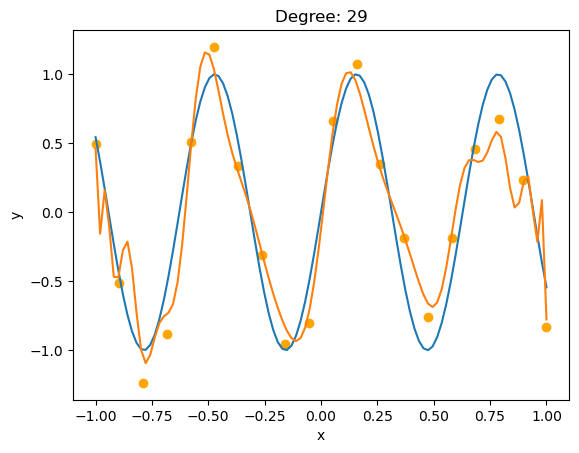

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.06124333664774895
Epoch 10000, Loss: 0.06124333664774895
Epoch 15000, Loss: 0.06124333664774895
Epoch 20000, Loss: 0.06124333664774895
Epoch 25000, Loss: 0.06124333664774895
Epoch 30000, Loss: 0.06124333664774895
Epoch 35000, Loss: 0.06124333664774895
Epoch 40000, Loss: 0.06124333664774895
Epoch 45000, Loss: 0.06124333664774895


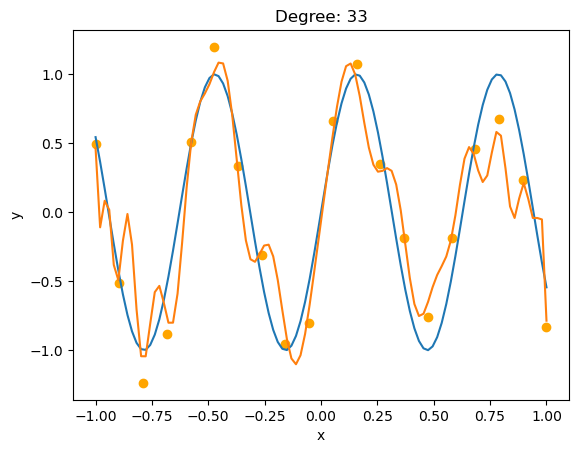

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.05192726105451584
Epoch 10000, Loss: 0.05192726105451584
Epoch 15000, Loss: 0.05192726105451584
Epoch 20000, Loss: 0.05192726105451584
Epoch 25000, Loss: 0.05192726105451584
Epoch 30000, Loss: 0.05192726105451584
Epoch 35000, Loss: 0.05192726105451584
Epoch 40000, Loss: 0.05192726105451584
Epoch 45000, Loss: 0.05192726105451584


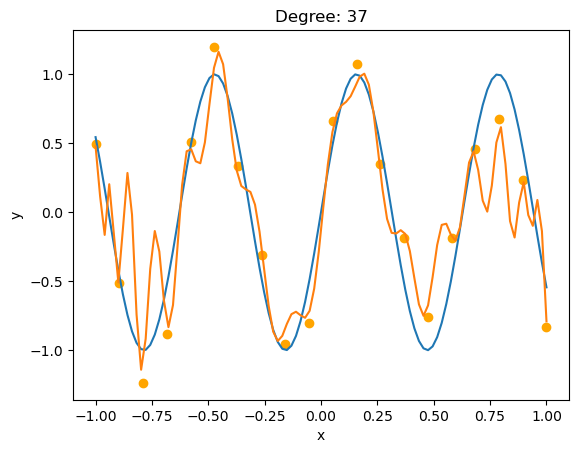

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.04798850417137146
Epoch 10000, Loss: 0.04798850417137146
Epoch 15000, Loss: 0.04798850044608116
Epoch 20000, Loss: 0.04798849672079086
Epoch 25000, Loss: 0.04798850044608116
Epoch 30000, Loss: 0.04798849672079086
Epoch 35000, Loss: 0.04798850044608116
Epoch 40000, Loss: 0.04798850044608116
Epoch 45000, Loss: 0.04798850044608116


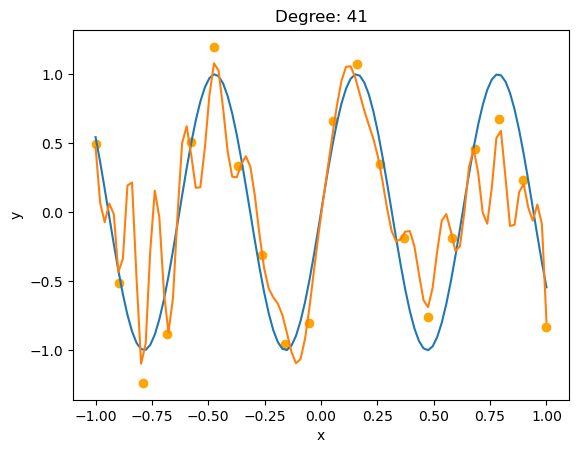

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.044910360127687454
Epoch 10000, Loss: 0.04491036385297775
Epoch 15000, Loss: 0.044910360127687454
Epoch 20000, Loss: 0.044910360127687454
Epoch 25000, Loss: 0.044910360127687454
Epoch 30000, Loss: 0.044910360127687454
Epoch 35000, Loss: 0.044910360127687454
Epoch 40000, Loss: 0.044910360127687454
Epoch 45000, Loss: 0.044910360127687454


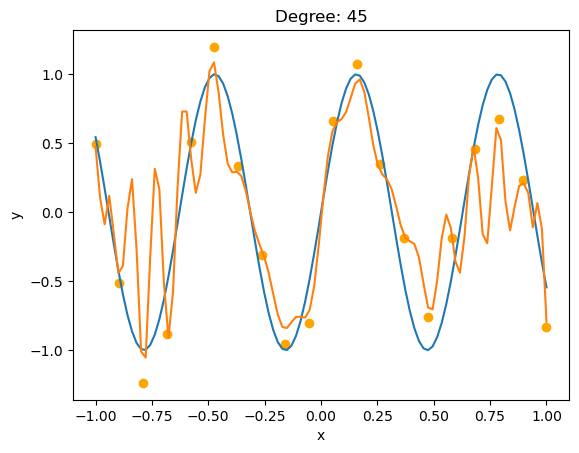

Epoch 0, Loss: 0.5026895403862
Epoch 5000, Loss: 0.03678528219461441
Epoch 10000, Loss: 0.03678528219461441
Epoch 15000, Loss: 0.03678528964519501
Epoch 20000, Loss: 0.03678528591990471
Epoch 25000, Loss: 0.03678528591990471
Epoch 30000, Loss: 0.03678528591990471
Epoch 35000, Loss: 0.03678528591990471
Epoch 40000, Loss: 0.03678528591990471
Epoch 45000, Loss: 0.03678528591990471


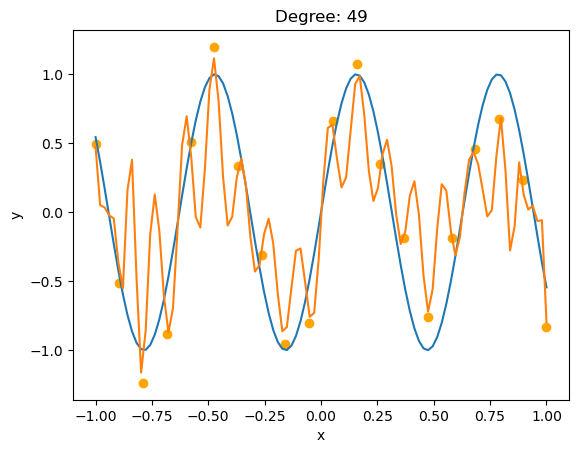

In [488]:
degrees = list(range(1, 50, 4))
model_list_regularized = []
train_loss_list_regularized = []
test_loss_list_regularized = []

for degree in degrees:
    X_train = get_chebyshev_polynomial(x_train, degree = degree)
    X = get_chebyshev_polynomial(x, degree = degree)
    X_test = get_chebyshev_polynomial(x_test, degree = degree)
    
    ## remove 0th order
    model, loss = fit_regression_L2(X_train[:, 1:], y_train, n_epochs = 50000, lr = 0.05, print_every = 5000, regularization_constant = 0.1)
    model_list_regularized.append(model)
    train_loss_list_regularized.append(loss)

    ## test set loss
    with t.inference_mode():
        loss = nn.MSELoss()
        y_pred = model(X_test[:, 1:])[:, 0]
        calculate_loss = loss(y_pred, y_test)
        test_loss_list_regularized.append(calculate_loss.item())
    
    sns.lineplot(df_true, x ="x", y="y")
    plt.title(f"Degree: {degree}")
    plt.scatter(df_train["x"], df_train["y"], c = "orange")
    plt.plot(x.numpy(), model(X[:, 1:]).detach().numpy())
    plt.show()

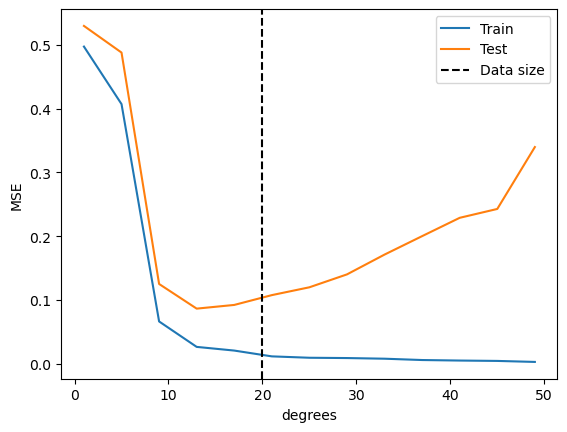

In [489]:
plt.plot(degrees, train_loss_list_regularized, label='Train')
plt.plot(degrees, test_loss_list_regularized, label='Test')
plt.axvline(x = 20, ls = '--', label = "Data size", c = "black")
plt.legend()
plt.xlabel("degrees")
plt.ylabel("MSE")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


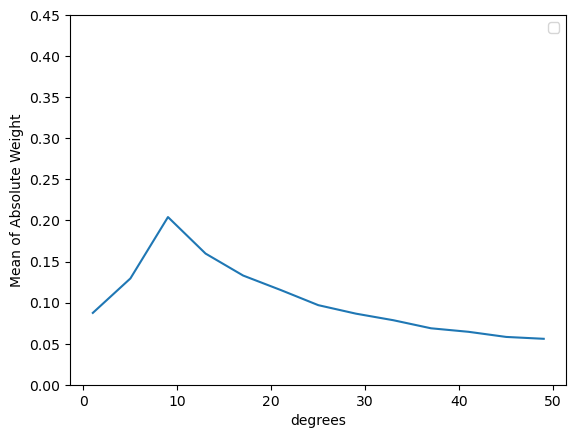

In [490]:
mean_weight_list_regularized = []

for model in model_list_regularized:
    weight = model.linear.weight
    mean_weight_list_regularized.append(weight.abs().mean().item())

plt.plot(degrees, mean_weight_list_regularized)
plt.legend()
plt.ylim(0.0, 0.45)
plt.xlabel("degrees")
plt.ylabel("Mean of Absolute Weight")
plt.show()

In [474]:
model_list_regularized

[LinReg(
   (linear): Linear(in_features=1, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=5, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=9, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=13, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=17, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=21, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=25, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=29, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=33, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=37, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=41, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=45, out_features=1, bias=True)
 ),
 LinReg(
   (linear): Linear(in_features=49, out_features=1, bias=True)
 ),
 0.111178599298